In [1]:
import pandas as pd
import numpy as np
import os
import networkx as nx
import osmnx as ox

%matplotlib inline

In [2]:
df = pd.read_csv('puma_distance_centroid.csv')
df.shape

(419, 7)

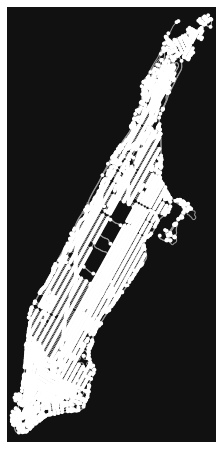

In [3]:
# download/model a street network for some city then visualize
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
fig, ax = ox.plot_graph(G)

In [4]:
# convert  MultiDiGraph to an undirected MultiGraph
M = ox.utils_graph.get_undirected(G)

# convert MultiDiGraph to a DiGraph without parallel edges
D = ox.utils_graph.get_digraph(G)

In [5]:
# convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,highway,street_count,ref,geometry
osmid,,,,,,
42421728,40.798048,-73.960044,traffic_signals,3,NaN,POINT (-73.96004 40.79805)
42421731,40.798654,-73.961474,traffic_signals,4,NaN,POINT (-73.96147 40.79865)
42421737,40.799244,-73.962873,traffic_signals,4,NaN,POINT (-73.96287 40.79924)
42421741,40.800429,-73.965691,traffic_signals,4,NaN,POINT (-73.96569 40.80043)
42421745,40.801398,-73.967996,traffic_signals,4,NaN,POINT (-73.96800 40.80140)


In [6]:
gdf_edges.head()
# in meters, might be off

osmid               name  \
u        v        key                                                       
42421728 42432736 0                          195743153  Central Park West   
         42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
42421731 42437916 0                            5671485   Manhattan Avenue   
         42432737 0                          195743186   Manhattan Avenue   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42432736 0      secondary   25 mph   False    False   86.258   
         42435337 0      secondary   25 mph   False     True   85.342   
         42421731 0      secondary      NaN   False    False  138.033   
42421731 42437916 0    residential      NaN   False     True   86.149   
         42432737 0    residential      NaN   False    False   85.611   

                                                                geometry  \
u        v        key                                                      
42421728 42432736 0    LINESTRING (-73.96004 40.79805, -73.95996 40.7...   
         42435337 0    LINESTRING (-73.96004 40.79805, -73.96011 40.7...   
         42421731 0    LINESTRING (-73.96004 40.79805, -73.96017 40.7...   
42421731 42437916 0    LINESTRING (-73.96147 40.79865, -73.96197 40.7...   
         42432737 0    LINESTRING (-73.96147 40.79865, -73.96098 40.7...   

                      lanes  ref access bridge tunnel width junction  
u        v        key                                                 
42421728 42432736 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
         42435337 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
         42421731 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
42421731 42437916 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN  
         42432737 0     NaN  NaN    NaN    NaN    NaN   NaN      NaN

In [7]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G2 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

In [8]:
# convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))
nx.set_edge_attributes(G, edge_centrality, "edge_centrality")

In [9]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [10]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-73.960044, Y=40.798048)
dest = ox.distance.nearest_nodes(G, X=-73.961474, Y=40.798654)

In [11]:
dist_km = nx.shortest_path_length(G=G,source = orig,target = dest, weight = 'length')/1000
#in kilometer
dist_km

0.13803300000000002

In [16]:
#empire state buidling and freedom tower
orig1 = ox.distance.nearest_nodes(G, X=-73.985428, Y=40.748817)
dest1 = ox.distance.nearest_nodes(G, X=-74.013382, Y=40.712742)

In [18]:
dist_km1 = nx.shortest_path_length(G=G,source = orig1,target = dest1, weight = 'length')/1000
dist_km1
#different route smaller

5.100210999999999

In [14]:
gdf_nodes['dist_km'] = nx.shortest_path_length(G=G,source = ox.distance.nearest_nodes(G, X=-73.985428, Y=40.748817),target = ox.distance.nearest_nodes(G, X=-73.985428, Y=40.748817), weight = 'length')/1000
#check with shortest path to verify have the distance between edges